**基于Jupyter的特征工程笔记本3: 特征降维**  
*作者: 陈颖祥，杨子唅*

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dimension-Reduction-特征降维" data-toc-modified-id="Dimension-Reduction-特征降维-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dimension Reduction 特征降维</a></span><ul class="toc-item"><li><span><a href="#Unsupervised-Methods-非监督方法" data-toc-modified-id="Unsupervised-Methods-非监督方法-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Unsupervised Methods 非监督方法</a></span><ul class="toc-item"><li><span><a href="#PCA-(Principal-Components-Analysis)-主成分分析" data-toc-modified-id="PCA-(Principal-Components-Analysis)-主成分分析-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>PCA (Principal Components Analysis) 主成分分析</a></span></li></ul></li><li><span><a href="#Supervised-Methods-监督方法" data-toc-modified-id="Supervised-Methods-监督方法-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Supervised Methods 监督方法</a></span><ul class="toc-item"><li><span><a href="#LDA-(Linear-Discriminant-Analysis)-线性判别分析" data-toc-modified-id="LDA-(Linear-Discriminant-Analysis)-线性判别分析-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>LDA (Linear Discriminant Analysis) 线性判别分析</a></span></li></ul></li></ul></li></ul></div>

**Reference**
- https://scikit-learn.org/stable/modules/decomposition.html#principal-component-analysis-pca
- https://sebastianraschka.com/faq/docs/lda-vs-pca.html
- https://en.wikipedia.org/wiki/Linear_discriminant_analysis

# Dimension Reduction 特征降维

经过数据预处理和特征选择，我们已经生成了一个很好的特征子集。但是有时该子集可能仍然包含过多特征，导致需要花费太多的计算能力用以训练模型。在这种情况下，我们可以使用降维技术进一步压缩特征子集。但这可能会降低模型性能。

同时，如果我们没有太多时间进行特征选择，我们也可以在数据预处理之后直接应用降维方法。我们可以使用降维算法来压缩原始特征空间直接生成特征子集。

具体来说，我们将分别介绍PCA和LDA（线性判别分析）。

## Unsupervised Methods 非监督方法

### PCA (Principal Components Analysis) 主成分分析

主成分分析（PCA）是一种无监督机器学习模型，其目标为利用线性变换将原始特征投影为一系列线性不相关的单位向量，而同时保留尽可能多的信息（方差）。您可以从我们在Github中编写的[repo](https://github.com/YC-Coder-Chen/Unsupervised-Notes/blob/master/PCA.md)中查看更多数学细节。

In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA

# 直接载入数据集
from sklearn.datasets import fetch_california_housing
dataset = fetch_california_housing()
X, y = dataset.data, dataset.target # 利用 california_housing 数据集来演示

# 选择前15000个观测点作为训练集
# 剩下的作为测试集
train_set = X[0:15000,:]
test_set = X[15000:,]
train_y = y[0:15000]

# 在使用主成分分析前，我们需要先对变量进行缩放操作，否则PCA将会赋予高尺度的特征过多的权重
from sklearn.preprocessing import StandardScaler
model = StandardScaler()
model.fit(train_set) 
standardized_train = model.transform(train_set)
standardized_test = model.transform(test_set)

# 开始压缩特征
compressor = PCA(n_components=0.9) 
# 将n_components设置为0.9 =>
# 即要求我们从所有主成分中选取的输出主成分至少能保留原特征中90%的方差
# 我们也可以通过设置n_components参数为整数直接控制输出的变量数目

compressor.fit(standardized_train) # 在训练集上训练
transformed_trainset = compressor.transform(standardized_train) # 转换训练集 (20000,5)
# 即我们从8个主成分中选取了前5个主成分，而这前5个主成分可以保证保留原特征中90%的方差

transformed_testset = compressor.transform(standardized_test) # 转换测试集
assert transformed_trainset.shape[1] == transformed_testset.shape[1] 
# 转换后训练集和测试集有相同的特征数

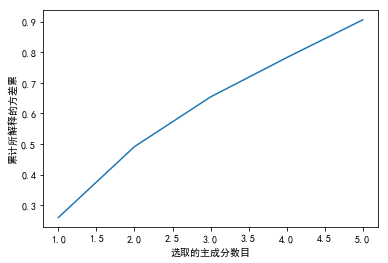

In [2]:
# 可视化 所解释的方差与选取的主成分数目之间的关系

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
%matplotlib inline


plt.plot(np.array(range(len(compressor.explained_variance_ratio_))) + 1, 
         np.cumsum(compressor.explained_variance_ratio_))
plt.xlabel('选取的主成分数目')
plt.ylabel('累计所解释的方差累')
plt.show(); # 前5个主成分可以保证保留原特征中90%的方差

## Supervised Methods 监督方法

### LDA (Linear Discriminant Analysis) 线性判别分析

与主成分分析（PCA）不同的是，线性判别分析（LDA）是一种有监督机器学习模型，旨在找到特征子集以最大化类线性可分离性，即希望投影望同一种类别数据的投影点尽可能的接近，而不同类别的数据的类别中心之间的距离尽可能的大。线性判别分析仅适用于分类问题，其假设各个类别的样本数据符合高斯分布，并且具有相同的协方差矩阵。

可以在sklearn的[官方网站](https://scikit-learn.org/stable/modules/lda_qda.html#lda-qda)上了解更多原理方面的详细信息。LDA会将原始变量压缩为（K-1）个，其中K是目标变量类别数。但是在sklearn中，通过将主成分分析的思想合并到LDA中，其可以进一步压缩变量。

In [3]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# LDA仅适用于分类问题
# 载入数据集
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data, iris.target

# iris 数据集使用前需要被打乱顺序
np.random.seed(1234)
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]

# 选择前100个观测点作为训练集
# 剩下的50个观测点测试集

train_set = X[0:100,:]
test_set = X[100:,]
train_y = y[0:100]
test_y = y[100:,]

# 在使用主成分分析前，我们需要先对变量进行缩放操作
# 因为LDA假定数据服从正态分布

from sklearn.preprocessing import StandardScaler # 我们也可以采用幂次变换
model = StandardScaler()
model.fit(train_set) 
standardized_train = model.transform(train_set)
standardized_test = model.transform(test_set)

# 开始压缩特征
compressor = LDA(n_components=2) # 将n_components设置为2
# n_components <= min(n_classes - 1, n_features)

compressor.fit(standardized_train, train_y)  # 在训练集上训练
transformed_trainset = compressor.transform(standardized_train) # 转换训练集 (20000,2)
transformed_testset = compressor.transform(standardized_test) # 转换测试集
assert transformed_trainset.shape[1] == transformed_testset.shape[1]
# 转换后训练集和测试集有相同的特征数

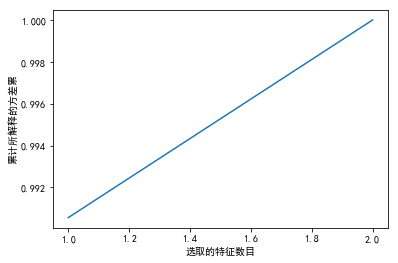

In [4]:
# 可视化 所解释的方差与选取的特征数目之间的关系
import matplotlib.pyplot as plt
plt.plot(np.array(range(len(compressor.explained_variance_ratio_))) + 1, 
         np.cumsum(compressor.explained_variance_ratio_))
plt.xlabel('选取的特征数目')
plt.ylabel('累计所解释的方差累')
plt.show(); # LDA将原始的4个变量压缩为2个，这2个变量即能解释100%的方差